# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
os.chdir('../')

import datetime
from pathlib import Path

import numpy as np

import torch

from collections import deque

import matplotlib.pyplot as plt

from unityagents import UnityEnvironment

from p3_collab_compet.agents.agent_ddpg import AgentDDPG

In [2]:
SEED = 42
SCORE_TARGET = 0.5
SCORE_WINDOW = 100

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# create folder architecture
PROJECT = 'p3_collab_compet'
START_TIME = datetime.datetime.now().strftime('%m-%d-%Y_%Hh%Mm')
EXPERIMENT_FOLDER = f'{PROJECT}/experiments/{START_TIME}'
Path(EXPERIMENT_FOLDER).mkdir(parents=True, exist_ok=False)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env_path = f'{PROJECT}/Tennis_Linux/Tennis.x86_64'
env = UnityEnvironment(file_name=env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Algorithm

The algorithm chosen for this task was DDPG, which has a successful history of SOTA performance and has been extensively documented and implemented.

DDPG leverages DQN to work with continuous action spaces, by adopting an Actor-Critic architecture: a network learns the policy while the other learns the value function. Moreover, DDPG introduces soft-updates, which allow to stabilize learning compared to DQN, and also noise regularization by means of the Ornstein-Uhlenbeck process.

While many drawbacks has been exposed by the community (see 3. Algorithm in P2 - Continuous Control report), I think this algorithm is simple enough to understand more complex architectures and I decided to explore it in detail.

In addition to this, several hyperparameters have been chosen for training the agent:

**Networks parameters**:
- actor_fc1_units = 400
- actor_fc2_units = 300

- critic_fc1_units = 400
- critic_fc2_units = 300

**Hyperparameters**:
- batch_size = 128        # minibatch size
- buffer_size = int(1e6)  # replay buffer size
- learn_every = 5         # how often to update the actor
- learn_iterations = 20   # number of update iterations
- gamma = 0.995           # discount factor
- tau = 0.001             # for soft update of target parameters
- actor_lr = 1e-4         # actor learning rate
- critic_lr = 1e-3        # critic learning rate
- noise_theta = 0.1       # theta for Ornstein-Uhlenbeck noise
- noise_sigma = 0.05      # sigma for Ornstein-Uhlenbeck noise

In [6]:
# define the agent
agent = AgentDDPG(
    state_size=state_size,
    action_size=action_size,
    hyperparams=dict(),
    device=DEVICE,
    seed=SEED
)

### 4. Training

In [7]:
# training hyperparameters
n_episodes = 500   # maximum number of training episodes
max_t = 1000       # maximum number of timesteps per episode

gamma = 0.95
gamma_rate = 0.01
gamma_scale = 1.0 - gamma_rate
gamma_final = 0.99

tau = 0.01
tau_rate = 0.001
tau_scale = 1.0 - tau_rate
tau_final = 0.001

noise_factor = 1.0
noise_scale = 1.0

scores = []                                 # scores for each episode
scores_window = deque(maxlen=SCORE_WINDOW)  # last 100 scores
scores_window_means = []                    # average max scores for each episode

# training loop
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    states = env_info.vector_observations              # get the current stat
    agent.reset()                                      # initialize agents
    score = np.zeros(num_agents)                       # initialize scores

    for t in range(max_t):
        actions = agent.select_action(states)       # get the action from the agent
        env_info = env.step(actions)[brain_name]    # send the action to the environment
        next_states = env_info.vector_observations  # get the next state
        rewards = env_info.rewards                  # get the reward
        dones = env_info.local_done                 # see if episode has finished

        # save experience tuple (of each agent) into replay buffer
        for i_agent in range(0, num_agents):
            experience = (
                states[i_agent],
                actions[i_agent],
                rewards[i_agent],
                next_states[i_agent],
                dones[i_agent]
            )
            agent.memory.add(data=experience)

        states = next_states  # roll over states to next time step
        score += rewards      # update the scores

        # Train each agent
        agent.learn_batch(timestep=t, gamma=gamma, tau=tau)

        if np.any(dones):
            break

    # Increase gamma discount factor up to gamma_final.
    gamma = gamma_final - gamma_scale * (gamma_final - gamma)
    tau = tau_final - tau_scale * (tau_final - tau)
    noise_scale *= noise_factor

    # By problem definition, the score is the max of both agents
    score = np.max(score)

    scores.append(score)
    scores_window.append(score)

    window_score_mean = np.mean(scores_window)  # save mean of window scores
    scores_window_means.append(window_score_mean)

    print(
        '\rEpisode {}\tEpisode total score: {:.2f}\tWindow Score: {:.2f}'
        .format(i_episode, score, window_score_mean),
        end=""
    )

    if i_episode % 100 == 0:
        print(
            '\rEpisode {}\tWindow Score: {:.2f}'
            .format(i_episode, window_score_mean)
        )

    if window_score_mean >= SCORE_TARGET:
        print(
            '\nEnvironment solved in {:d} episodes!\tWindow Score: {:.2f}'
            .format(i_episode, window_score_mean)
        )

        print(f'Saving weights into {EXPERIMENT_FOLDER} folder...')
        torch.save(
            agent.actor_local.state_dict(),
            f'{EXPERIMENT_FOLDER}/weights_actor_episode_{i_episode}.pth'
        )
        torch.save(
            agent.critic_local.state_dict(),
            f'{EXPERIMENT_FOLDER}/weights_critic_episode_{i_episode}.pth'
        )

        break


Episode 100	Window Score: 0.00e: 0.10	Window Score: 0.00
Episode 200	Window Score: 0.00e: 0.00	Window Score: 0.00
Episode 300	Window Score: 0.04e: 0.00	Window Score: 0.04
Episode 400	Window Score: 0.22e: 0.10	Window Score: 0.22
Episode 438	Episode total score: 2.60	Window Score: 0.52
Environment solved in 438 episodes!	Window Score: 0.52
Saving weights into p3_collab_compet/experiments/04-26-2020_21h30m folder...


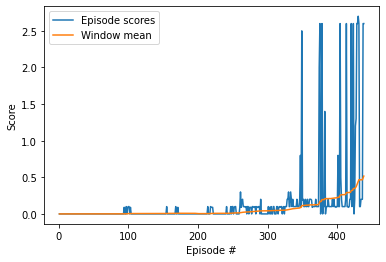

Saving figure into p3_collab_compet/experiments/04-26-2020_21h30m folder...


In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label='Episode scores')
plt.plot(np.arange(1, len(scores) + 1), scores_window_means, label='Window mean')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# save figure to file
print(f'Saving figure into {EXPERIMENT_FOLDER} folder...')
fig.savefig(f'{EXPERIMENT_FOLDER}/scores.png')

In [9]:
# close the environment
env.close()

### 5. Future work

#### 5.1. Further improvements

DDPG seems to learn quite fast but at the cost of really high variance, which is something that should be addressed. The use of more complex designs that take care of the common drawbacks of DDPG, such as TD3, could yield a more stable training. In addition to this, parallelization can increase the speed of learning.


#### 5.2. Other algorithms

Other algorithms that I think could be interesting to benchmark with DDPG are the already tested TD3, TRPO and PPO. The differences in these algorithms both in its design and performance can yield some insights on why some algorithms seem to perform better than others.

### 6. References

**DDPG paper**: https://arxiv.org/abs/1509.02971

**DDPG explanation**: https://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html

**DDPG implementations**: 
- https://github.com/udacity/deep-reinforcement-learning
- https://github.com/snhwang/p3_collab-compet